In [2]:
!pip install segmentation-models-pytorch[all]


In [3]:
!pip install albumentations


In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
!pip install wandb --upgrade

In [6]:
# import wandb

# wandb.login()

In [7]:
data_dir = '/content/drive/MyDrive/MEDAI/Kvasir-SEG/'

In [8]:
X_folder = data_dir + 'images'
Y_folder = data_dir + 'masks'

In [9]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn


all_in = [f for f in os.listdir(X_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
all_out = [f for f in os.listdir(Y_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]


In [10]:

# Get full paths (assuming matching order and names)
image_paths = [os.path.join(X_folder, f) for f in all_in]
mask_paths = [os.path.join(Y_folder, f) for f in all_out]


# # Train-test split on file paths, NOT on loaded images
# X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)



In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For training
train_transform = A.Compose([
    A.Resize(320, 320),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

# For testing/validation
val_transform = A.Compose([
    A.Resize(320, 320),
    A.Normalize(),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [12]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[idx]).convert('L'))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float() / 255.0
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask


In [13]:
# class CustomDataset(Dataset):
#     def __init__(self, image_paths, mask_paths):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = Image.open(self.image_paths[idx]).convert('RGB').resize((320, 320))
#         mask = Image.open(self.mask_paths[idx]).convert('L').resize((320, 320))

#         image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0
#         mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0) / 255.0

#         return image, mask


In [14]:
!pip install torchmetrics

TRAINING AND VALIDATING WITH WANDB

In [15]:
# import wandb
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split
# import segmentation_models_pytorch as smp
# from glob import glob


# def train():
#     wandb.init()
#     config = wandb.config

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)



#     train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
#     val_dataset = CustomDataset(X_val, y_val, transform=val_transform)

#     # train_dataset = CustomDataset(X_train, y_train)
#     # val_dataset = CustomDataset(X_val, y_val)

#     train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, pin_memory=True)
#     val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, pin_memory=True)


#     model = smp.Unet(
#         encoder_name=config.encoder_name,
#         encoder_weights=config.encoder_weights,
#         in_channels=3,
#         classes=1
#     ).to(device)


#     if config.optimizer == "Adam":
#         optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
#     elif config.optimizer == "AdamW":
#         optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)


#     criterion = smp.losses.DiceLoss(mode="binary")

#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, verbose=True
# )

#     for epoch in range(11):
#         model.train()
#         total_loss = 0

#         for batch_features, batch_labels in train_loader:
#             batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(batch_features)
#             outputs = torch.sigmoid(outputs)

#             loss = criterion(outputs, batch_labels)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         avg_loss = total_loss / len(train_loader)

#         model.eval()
#         val_loss = 0


#         with torch.no_grad():
#             for batch_features, batch_labels in val_loader:
#                 batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

#                 outputs = model(batch_features)
#                 outputs = torch.sigmoid(outputs)

#                 loss = criterion(outputs, batch_labels)
#                 val_loss += loss.item()

#         avg_val_loss = val_loss / len(val_loader)

#         print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

#         wandb.log({
#             "epoch": epoch,
#             "train_loss": avg_loss,
#             "val_loss": avg_val_loss,
#         })

#         scheduler.step(avg_val_loss)


In [16]:
# sweep_config = {
#     'method': 'bayes',
#     'metric': {'name': 'dice_loss', 'goal': 'minimize'},
#     'parameters': {
#         # 'epochs' : {'min':10, 'max': 30},
#         'learning_rate': {'min': 0.00009, 'max': 0.001,},
#         'batch_size': {'values': [4, 8, 16]},
#         'optimizer': {'values': ["Adam", "AdamW"]},
#         'encoder_name': {'values': ["efficientnet-b4", "resnet18"]},
#         'encoder_weights': {'values': ["imagenet"]},
#         # 'loss_function': "DiceLoss",
#         # 'threshold': {'min': 0.3, 'max': 0.7},
#         'model_architecture': {'values': ["Unet"]}
#     }
# }

# sweep_id = wandb.sweep(sweep_config, project="colon-polyp-segmentation-3")
# wandb.agent(sweep_id, function=train,count = 5)


TRAINING USING BEST PARAMS

In [17]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
import segmentation_models_pytorch as smp
from torchmetrics.classification import JaccardIndex


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
val_dataset = CustomDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)


model = smp.Unet(
    encoder_name= 'efficientnet-b4',
    encoder_weights= 'imagenet',
    in_channels=3,
    classes=1
).to(device)

optimizer = optimizer = optim.AdamW(model.parameters(), lr=0.0001)
criterion = smp.losses.DiceLoss(mode="binary")



for epoch in range(11):
    model.train()
    total_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        outputs = torch.sigmoid(outputs)

        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    model.eval()

    val_loss = 0

    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)
            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1 | Train Loss: 0.7354 | Val Loss: 0.7350
Epoch 2 | Train Loss: 0.7053 | Val Loss: 0.7189
Epoch 3 | Train Loss: 0.6966 | Val Loss: 0.7138
Epoch 4 | Train Loss: 0.6933 | Val Loss: 0.7116
Epoch 5 | Train Loss: 0.6892 | Val Loss: 0.7103
Epoch 6 | Train Loss: 0.6872 | Val Loss: 0.7092
Epoch 7 | Train Loss: 0.6861 | Val Loss: 0.7080
Epoch 8 | Train Loss: 0.6866 | Val Loss: 0.7091
Epoch 9 | Train Loss: 0.6868 | Val Loss: 0.7069
Epoch 10 | Train Loss: 0.6844 | Val Loss: 0.7086
Epoch 11 | Train Loss: 0.6839 | Val Loss: 0.7074


In [18]:
torch.cuda.empty_cache()

Testing

In [19]:
test_dataset = CustomDataset(X_test, y_test, trasform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)

In [20]:
def compute_iou(preds, targets, eps=1e-7):
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = ((preds + targets) >= 1).float().sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def compute_dice(preds, targets, eps=1e-7):
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + eps)
    return dice.mean().item()


model.eval()
ious, dices = [], []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)
        outputs = torch.sigmoid(outputs)
        binary_preds = (outputs > 0.5).float()
        binary_labels = (batch_labels > 0.5).float()

        ious.append(compute_iou(binary_preds, binary_labels))
        dices.append(compute_dice(binary_preds, binary_labels))

avg_iou = sum(ious) / len(ious)
avg_dice = sum(dices) / len(dices)

print(f"Average IoU on test set: {avg_iou:.4f}")
print(f"Average Dice Score on test set: {avg_dice:.4f}")


Average IoU on test set: 0.8137
Average Dice Score on test set: 0.8833


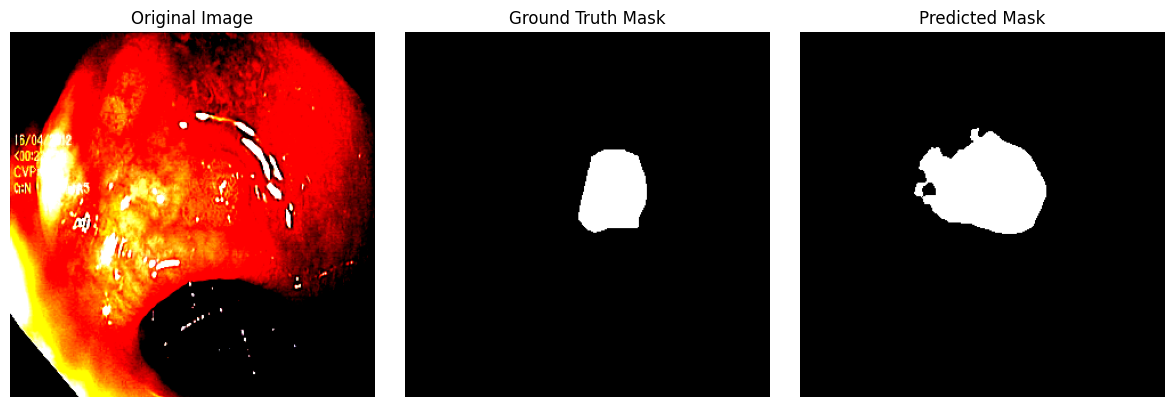

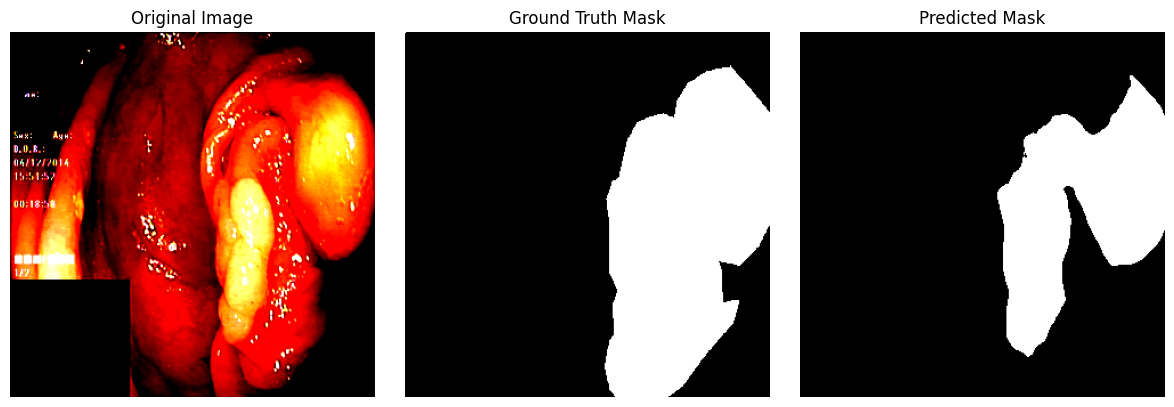

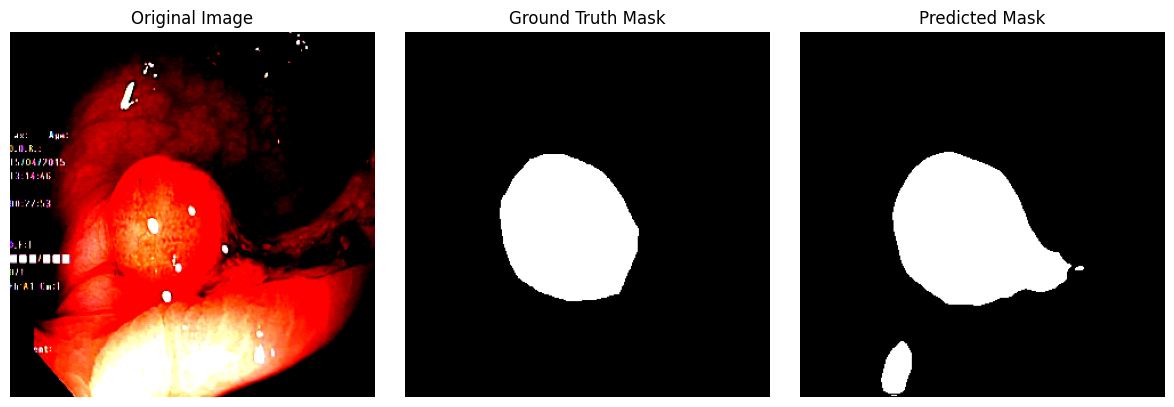

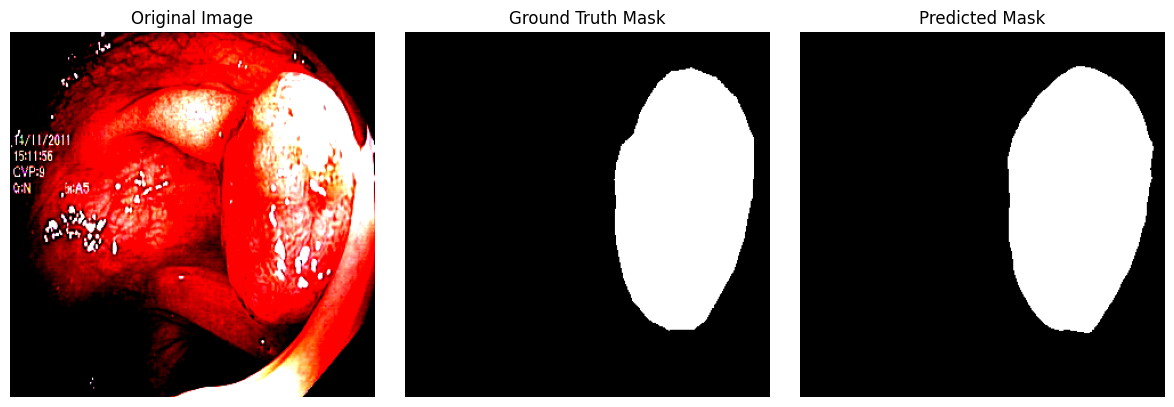

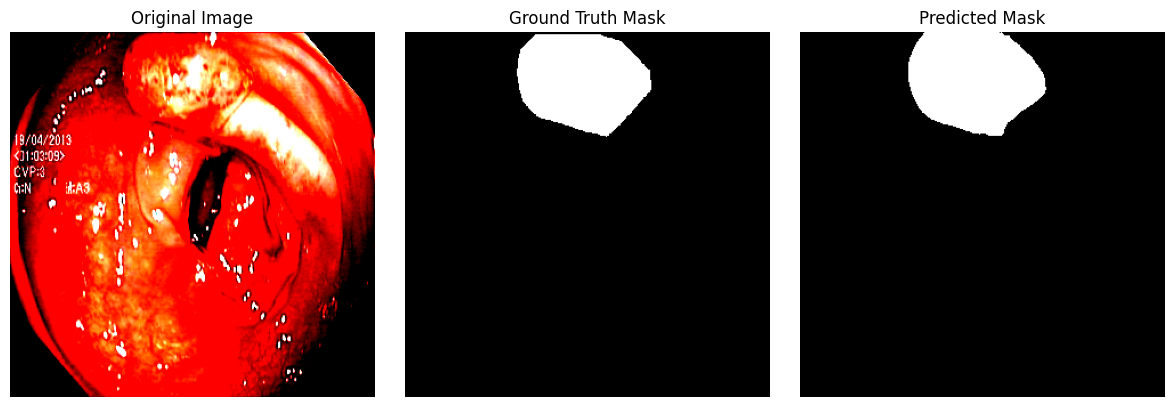

In [21]:
import matplotlib.pyplot as plt

# Number of examples to visualize
num_samples_to_plot = 5
count = 0

model.eval()

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        outputs = torch.sigmoid(outputs)

        # Binarize predictions and labels
        binary_preds = (outputs > 0.5).float()
        binary_labels = (batch_labels > 0.5).float()

        for i in range(batch_features.shape[0]):
            if count >= num_samples_to_plot:
                break

            image = batch_features[i].cpu().permute(1, 2, 0).numpy()
            gt_mask = binary_labels[i].cpu().squeeze().numpy()
            pred_mask = binary_preds[i].cpu().squeeze().numpy()

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            count += 1

        if count >= num_samples_to_plot:
            break
